In [1]:
import cftime
import nc_time_axis
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from xclim import sdba
import numpy as np

In [2]:
# Create toy data to explore bias adjustment, here fake temperature timeseries
t = xr.cftime_range("2000-01-01", "2030-12-31", freq="D", calendar="noleap")
ref = xr.DataArray(
    (
        -20 * np.cos(2 * np.pi * t.dayofyear / 365)
        + 2 * np.random.random_sample((t.size,))
        + 273.15
        + 0.1 * (t - t[0]).days / 365
    ),  # "warming" of 1K per decade,
    dims=("time",),
    coords={"time": t},
    attrs={"units": "K"},
)
sim = xr.DataArray(
    (
        -18 * np.cos(2 * np.pi * t.dayofyear / 365)
        + 2 * np.random.random_sample((t.size,))
        + 273.15
        + 0.11 * (t - t[0]).days / 365
    ),  # "warming" of 1.1K per decade
    dims=("time",),
    coords={"time": t},
    attrs={"units": "K"},
)

ref = ref.sel(time=slice(None, "2015-01-01"))
hist = sim.sel(time=slice(None, "2015-01-01"))

In [3]:
sim

<xarray.DataArray (time: 11315)>
array([256.478356, 256.219207, 255.378464, ..., 259.968689, 259.453359,
       260.110644])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2030-12-31 00:00:00
Attributes:
    units:    K

In [4]:
ref

<xarray.DataArray (time: 5476)>
array([254.053597, 254.537127, 254.806237, ..., 254.967355, 256.164094,
       255.61819 ])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2015-01-01 00:00:00
Attributes:
    units:    K

In [5]:
hist

<xarray.DataArray (time: 5476)>
array([256.478356, 256.219207, 255.378464, ..., 257.239452, 258.422912,
       257.426439])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2015-01-01 00:00:00
Attributes:
    units:    K

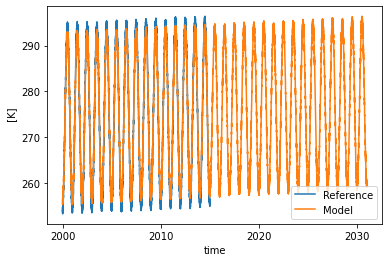

In [6]:
ref.plot(label="Reference")
sim.plot(label="Model")
plt.legend()

In [7]:
QM = sdba.EmpiricalQuantileMapping.train(
    ref, hist, nquantiles=20, group="time.month", kind="*"
)

In [8]:
QM.ds

<xarray.Dataset>
Dimensions:    (quantiles: 20, month: 12)
Coordinates:
  * quantiles  (quantiles) float64 0.025 0.075 0.125 0.175 ... 0.875 0.925 0.975
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    af         (month, quantiles) float64 0.992 0.9921 0.9923 ... 0.993 0.9927
    hist_q     (month, quantiles) float64 256.0 256.3 256.6 ... 259.3 259.9
Attributes:
    group:               time.month
    group_compute_dims:  ['time']
    group_window:        1
    _xclim_adjustment:   {"py/object": "xclim.sdba.adjustment.EmpiricalQuanti...
    adj_params:          EmpiricalQuantileMapping(group=Grouper(add_dims=[], ...

In [9]:
def get_quantiles(da, quantiles, timescale='monthly'):
    """Get quantiles.
    Required because sdba.EmpiricalQuantileMapping.train only
    outputs hist_q and not others like ref_q.    
    """

    if timescale == 'monthly':
        months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
        q_list = []
        for month in months:
            mth = sdba.nbutils.quantile(da[da['time'].dt.month == month], quantiles, ['time'])
            q_list.append(mth)
        da_q = xr.concat(q_list, dim='month')
        da_q.coords['month'] = months
        #da_q = da_q.transpose('quantiles', 'month')
    elif timescale == 'annual':
        da_q = nbutils.quantile(da, quantiles, ['time'])
        #da_q = da_q.transpose('quantiles', 'lat', 'lon')
    else:
        raise ValueError('Invalid timescale: {timescale}')
        
    da_q.attrs['standard_name'] = 'Quantiles'
    da_q.attrs['long_name'] = 'Quantiles'

    return da_q

In [10]:
QM.ds['hist_q'].values = get_quantiles(sim, QM.ds['quantiles'].values)

In [11]:
scen = QM.adjust(sim, extrapolation="constant", interp="nearest")

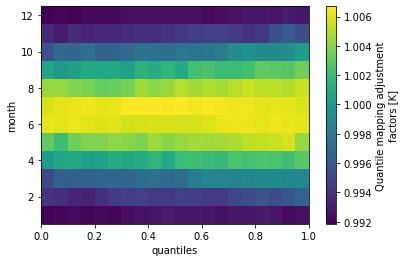

In [12]:
QM.ds['af'].plot()

In [13]:
df = scen.to_dataframe().reset_index()

In [14]:
df['sim'] = sim.to_dataframe(name='sim').reset_index()['sim']

In [15]:
df['af'] = df['scen'] / df['sim']

In [16]:
df

,time,scen,sim,af
0,2000-01-01 00:00:00,254.459165,256.478356,0.992127
1,2000-01-02 00:00:00,254.171114,256.219207,0.992006
2,2000-01-03 00:00:00,253.337091,255.378464,0.992006
3,2000-01-04 00:00:00,254.033495,256.080479,0.992006
4,2000-01-05 00:00:00,254.748373,256.769858,0.992127
...,...,...,...,...
11310,2030-12-27 00:00:00,257.483439,259.402795,0.992601
11311,2030-12-28 00:00:00,258.069949,259.955775,0.992746
11312,2030-12-29 00:00:00,258.082770,259.968689,0.992746
11313,2030-12-30 00:00:00,257.533628,259.453359,0.992601


In [17]:
df['month'] = sim['time'].dt.month.values

In [18]:
month_df = df[df['month'] == 1].sort_values('sim', ascending=False)

In [19]:
month_df

,time,scen,sim,af,month
9885,2027-01-31 00:00:00,260.458916,262.442641,0.992441,1
10248,2028-01-29 00:00:00,260.444989,262.428609,0.992441,1
10250,2028-01-31 00:00:00,260.369374,262.352418,0.992441,1
10980,2030-01-31 00:00:00,260.362003,262.344990,0.992441,1
10612,2029-01-28 00:00:00,260.336811,262.319606,0.992441,1
...,...,...,...,...,...
370,2001-01-06 00:00:00,253.598325,255.641803,0.992006,1
733,2002-01-04 00:00:00,253.534339,255.577301,0.992006,1
736,2002-01-07 00:00:00,253.524454,255.567336,0.992006,1
374,2001-01-10 00:00:00,253.488833,255.531429,0.992006,1


In [19]:
961 / 20

48.05

In [20]:
month_df['af'] = month_df['af'].round(6)

In [21]:
month_df

,time,scen,sim,af,month
9885,2027-01-31 00:00:00,260.458916,262.442641,0.992441,1
10248,2028-01-29 00:00:00,260.444989,262.428609,0.992441,1
10250,2028-01-31 00:00:00,260.369374,262.352418,0.992441,1
10980,2030-01-31 00:00:00,260.362003,262.344990,0.992441,1
10612,2029-01-28 00:00:00,260.336811,262.319606,0.992441,1
...,...,...,...,...,...
370,2001-01-06 00:00:00,253.598325,255.641803,0.992006,1
733,2002-01-04 00:00:00,253.534339,255.577301,0.992006,1
736,2002-01-07 00:00:00,253.524454,255.567336,0.992006,1
374,2001-01-10 00:00:00,253.488833,255.531429,0.992006,1


In [22]:
counts = month_df['af'].value_counts()

In [23]:
len(counts)

20

In [24]:
counts

0.992275    62
0.992633    55
0.992933    53
0.992127    52
0.992228    52
0.992727    50
0.992718    50
0.992078    49
0.992751    48
0.992082    47
0.992544    47
0.992006    47
0.992772    47
0.992362    46
0.992683    45
0.992292    44
0.992492    44
0.992861    43
0.992778    42
0.992441    38
Name: af, dtype: int64

In [25]:
np.sort(counts.index.values)

array([0.992006, 0.992078, 0.992082, 0.992127, 0.992228, 0.992275,
       0.992292, 0.992362, 0.992441, 0.992492, 0.992544, 0.992633,
       0.992683, 0.992718, 0.992727, 0.992751, 0.992772, 0.992778,
       0.992861, 0.992933])

In [26]:
np.round(np.sort(QM.ds['af'].sel(month=1).values), 6)

array([0.992006, 0.992078, 0.992082, 0.992127, 0.992228, 0.992275,
       0.992292, 0.992362, 0.992441, 0.992492, 0.992544, 0.992633,
       0.992683, 0.992718, 0.992727, 0.992751, 0.992772, 0.992778,
       0.992861, 0.992933])